# Welcome to the WHOI Summer Math Review in Data Analysis!

This course will be taught in **Python** in the format of a Jupyter notebook, which you will be sent following the course! That way, you can try out the exercises interactively as well, as all of the data will be stored in this format for your later use.

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
</script>

**Major Learning Objectives**
- Load netCDF files as well as a FASTA file for biological sequences
- Learn skills for plotting and analyzing data in 2D and 3D
- Linear and multinomial regression
- Statistical tests

### netCDF data type manipulation
The netCDF data we will be working with come from the [UCAR Community Programs Database](https://www.unidata.ucar.edu/software/netcdf/examples/files.html) and include sea surface temperature data which were collected for the purposes of use with the IPCC climate assessment and modeling efforts. The data should all be stored in the same location as this Jupyter notebook for the code to work when you try it out on your own later. It should be in the zip file you receive as part of the course, but it also is freely downloadable from the embedded link.

*Note*: you will also need to have `netCDF4`, a Python package for working with netCDF data, installed. You can install it either by creating a `conda` environment to use with your Jupyter notebook that has this package available, or by downloading the package directly in Anaconda Navigator.

You can opt for the second option by navigating to the "Environments" tab in Anaconda Navigator, searching for `netCDF4` to add to the currently active environment which you used to launch your Jupyter Notebook instance (which should couple together by default), and following the install dialog.

![netCDF4 Install](images/anacondanavigator.png)

**After** you have `netCDF4` installed, you should be able to call the following import commands to make the libraries accessible to your current notebook instance. 

In addition to `netCDF4`, we'll also be using `pandas`, `scipy`, `datetime`, `numpy`, `matplotlib` and potentially `plotnine`. If you don't have any of these packages, you can use the same import procedure on Anaconda Navigator.

In [108]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
from netCDF4 import Dataset
import matplotlib.pyplot as plt

In [3]:
from Bio import SeqIO

## A primer on `netCDF`

A huge problem in environmental data is **dimensionality**. Because we have at least 4 dimensions - horizontal space on two axes, vertical space, and the axis of time - it can be super unwieldy to deal with data even from a single site. To get a sense of how big these numbers can be, let's consider a patch of ocean 1 meter by 1 meter in size. Let's say we're only interested in phytoplankton.

So, we can say for the sake of argument we only care about the surface one meter of water, but we need subdivisions of *micro*meters to say anything useful about the critters we're interested in. We need to observe the evolution of a phytoplankton bloom over 10 days, and we need time points every 1 hour to track diversity. All of the sudden, we have: 

$$\begin{equation} \textrm{height} \times \textrm{width} \times \textrm{depth} \times \textrm{depth}  = \left( 1 \textrm{ m} \times \frac{10^6 \mu \textrm{m}}{\textrm{m}} \right) \times \left( 1 \textrm{ m} \times \frac{10^6 \mu \textrm{m}}{\textrm{m}} \right) \times \left( 1 \textrm{ m} \times \frac{10^6 \mu \textrm{m}}{\textrm{m}} \right) \times \left( 10 \textrm{ days} \times \frac{24 \textrm{ hours}}{\textrm{day}} \right)\end{equation} = \\2.40 \times 10^{20} \textrm{ hourly snapshots of 1 micrometer size}$$

So...in 1 cubic meter of water, if we use high enough resolution, we can get on the order of $10^{20}$ data points with *hourly* sampling in a single 10-day cruise. That's before we even try any fancy tricks with data processing. This is why we need `netCDF`!

You are free to store your data as a CSV or other spreadsheet, but it just won't be packed as tidily as a `netCDF` can be, which is why so many earth scientists use this format for their 3-dimensional data. A lot of the physical oceanographic resources that you can find will be stored as a `netCDF` file (you will know this by their `.nc` extension).

## Getting started with the `netcdf4` package

If you've worked with `netCDF` files before, you've almost definitely used `MATLAB`. In this course, we'll try out an alternative option: the `netcdf4` package in `Python`. This should help those of you that use `Python` for most everything else in your research!

To get started, we want to perform the analogous operation to the `ncdisp` functionality in `MATLAB`. This prints out the variables inside of our `netCDF` file, so that we have a bit of an idea about how to best access them.

`netcdf4` does *not* have this function. However, we can still check out our variable names. To begin, let's use the `Dataset` package that we loaded.

### Loading packages in Python

When we load packages in Python, we can use the `from` directive to specifically load a particular function that we plan to use from inside a function a lot. That's what we did with `Dataset` above:

```
from netCDF4 import Dataset
```

This tells `Python` to be selective, and give us the function that we need from this package. This is the most important function in `netCDF`!

In [4]:
surface_temperatures = Dataset('data/tos_O1_2001-2002.nc')

#### *Remember*: you need to make sure that you have the NC file in the `data` directory for this to work!

Let's take a look at what we have inside this `netCDF` file!

First, let's check out the `ncattrs`, which are a grouping of all of the *attributes*, or metadata, that characterize our `netCDF` file.

In [5]:
surface_temperatures.ncattrs()

['title',
 'institution',
 'source',
 'contact',
 'project_id',
 'table_id',
 'experiment_id',
 'realization',
 'cmor_version',
 'Conventions',
 'history',
 'references',
 'comment']

We can grab an individual `netCDF` attribute by specifying it as a slot or name within this `Python` object.

In [6]:
surface_temperatures.title

'IPSL  model output prepared for IPCC Fourth Assessment SRES A2 experiment'

Or, we can get a more global view of all of the variables and data inside of our `netCDF` object.

In [7]:
print(surface_temperatures)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: IPSL  model output prepared for IPCC Fourth Assessment SRES A2 experiment
    institution: IPSL (Institut Pierre Simon Laplace, Paris, France)
    source: IPSL-CM4_v1 (2003) : atmosphere : LMDZ (IPSL-CM4_IPCC, 96x71x19) ; ocean ORCA2 (ipsl_cm4_v1_8, 2x2L31); sea ice LIM (ipsl_cm4_v
    contact: Sebastien Denvil, sebastien.denvil@ipsl.jussieu.fr
    project_id: IPCC Fourth Assessment
    table_id: Table O1 (13 November 2004)
    experiment_id: SRES A2 experiment
    realization: 1
    cmor_version: 0.96
    Conventions: CF-1.0
    history: YYYY/MM/JJ: data generated; YYYY/MM/JJ+1 data transformed  At 16:37:23 on 01/11/2005, CMOR rewrote data to comply with CF standards and IPCC Fourth Assessment requirements
    references: Dufresne et al, Journal of Climate, 2015, vol XX, p 136
    comment: Test drive
    dimensions(sizes): lon(180), lat(170), time(24), bnds(2)
    variables(dime

### Zooming in on a few of these features

```
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: IPSL  model output prepared for IPCC Fourth Assessment SRES A2 experiment
    institution: IPSL (Institut Pierre Simon Laplace, Paris, France)
    source: IPSL-CM4_v1 (2003) : atmosphere : LMDZ (IPSL-CM4_IPCC, 96x71x19) ; ocean ORCA2 (ipsl_cm4_v1_8, 2x2L31); sea ice LIM (ipsl_cm4_v
    contact: Sebastien Denvil, sebastien.denvil@ipsl.jussieu.fr
    project_id: IPCC Fourth Assessment
    table_id: Table O1 (13 November 2004)
    experiment_id: SRES A2 experiment
    realization: 1
    cmor_version: 0.96
    Conventions: CF-1.0
    history: YYYY/MM/JJ: data generated; YYYY/MM/JJ+1 data transformed  At 16:37:23 on 01/11/2005, CMOR rewrote data to comply with CF standards and IPCC Fourth Assessment requirements
    references: Dufresne et al, Journal of Climate, 2015, vol XX, p 136
    comment: Test drive
    dimensions(sizes): lon(180), lat(170), time(24), bnds(2)
    variables(dimensions): float64 lon(lon), float64 lon_bnds(lon,bnds), float64 lat(lat), float64 lat_bnds(lat,bnds), float64 time(time), float64 time_bnds(time,bnds), float32 tos(time,lat,lon)
    groups: 
```

A few things jump out right away:

- dimensions(sizes): lon(180), lat(170), time(24), bnds(2)
- variables(dimensions): float64 lon(lon), float64 lon_bnds(lon,bnds), float64 lat(lat), float64 lat_bnds(lat,bnds), float64 time(time), float64 time_bnds(time,bnds), float32 tos(time,lat,lon)

We also have some metadata about where the data came from and what it was used for.

### Let's try grabbing out some of these data variables!

In [8]:
surface_temperatures.variables

OrderedDict([('lon', <class 'netCDF4._netCDF4.Variable'>
              float64 lon(lon)
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  axis: X
                  bounds: lon_bnds
                  original_units: degrees_east
              unlimited dimensions: 
              current shape = (180,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lon_bnds', <class 'netCDF4._netCDF4.Variable'>
              float64 lon_bnds(lon, bnds)
              unlimited dimensions: 
              current shape = (180, 2)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lat', <class 'netCDF4._netCDF4.Variable'>
              float64 lat(lat)
                  standard_name: latitude
                  long_name: latitude
                  units: degrees_north
                  axis: Y
                  bounds: lat_bnds
        

Having a list of variables, we can extract the actual data associated with each variable using *array syntax* in `Python`.

In [9]:
 surface_temperatures['lat'][:]

masked_array(data=[-79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
                   -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5,
                   -63.5, -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5,
                   -55.5, -54.5, -53.5, -52.5, -51.5, -50.5, -49.5, -48.5,
                   -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
                   -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5,
                   -31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5, -24.5,
                   -23.5, -22.5, -21.5, -20.5, -19.5, -18.5, -17.5, -16.5,
                   -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,
                    -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
                     0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,
                     8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,
                    16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,
                    24.5,

But **remember**, these are multi-dimensional values (that are compatible with the other values in this `netCDF` file). So we can't just use them like a column in a `DataFrame`, like you might have been introduced to in the `Python` course.

To get started, let's subset our data out (the first time point), so that it's a bit easier to work with.

If you remember from above, our "tos" variable has three dimensions: time, latitude, and longitude, in that order. So we'll take the zero-indexed first entry in `tos`, and then start with all of the latitude and longitude values.

In [10]:
sst = surface_temperatures['tos'][0,:,:]

In [11]:
sst

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [271.4374694824219, 271.4379577636719, 271.43841552734375, ...,
         271.4361877441406, 271.4365539550781, 271.4369812011719],
        [271.4451904296875, 271.44525146484375, 271.4453125, ...,
         271.445068359375, 271.4450988769531, 271.44512939453125],
        [271.4591979980469, 271.45916748046875, 271.4591369628906, ...,
         271.459228515625, 271.459228515625, 271.4591979980469]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

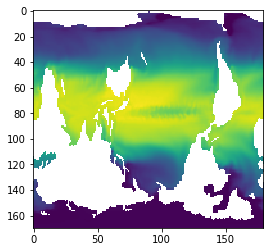

In [12]:
plt.imshow(sst, interpolation='none')

This looks recognizable, but it's pretty...upside down. Let's try naïvely plotting out these data for sea surface temperatures (the `tos` variable)!  This time, let's try a smaller slice on latitude and longitude.

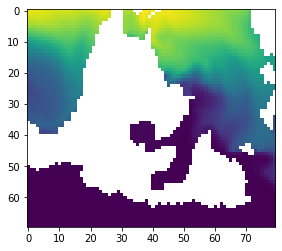

In [13]:
sst = surface_temperatures['tos'][0,100:400,100:400]
plt.imshow(sst, interpolation='none')
plt.show()

**Does anyone recognize this map**? Notice that here, we have some null values, which are being masked as white points on the plot above. Let's convert these to black, and use the old friend of the physical oceanographer: the "jetcolors" colormap (though it's important to note that there are a lot of [opinions](https://gorelik.net/2020/08/17/what-is-the-biggest-problem-of-the-jet-and-rainbow-color-maps-and-why-is-it-not-as-evil-as-i-thought/) on whether this is a totally terrible colormap to use).

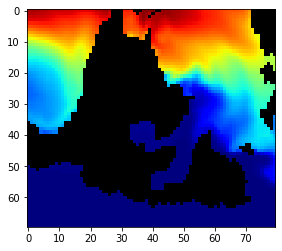

In [14]:
cmap = plt.cm.jet
cmap.set_bad('black',1.) # set the missing points to black
plt.imshow(sst, interpolation='nearest', cmap=cmap)

Is it any clearer now where we might be? To figure it out, let's use the latitude and longitude variables for the same slice of data. For this, we have to combine three different arrays, so we'll use the function `pcolor` to specify different axes.

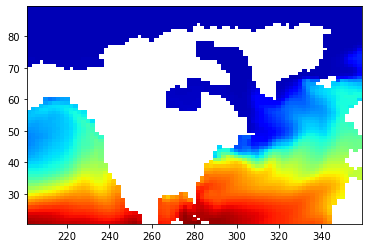

In [25]:
lon = surface_temperatures['lon'][100:]
lat = surface_temperatures['lat'][100:]
sst = surface_temperatures['tos'][0, 100:, 100:]

# We use vmin and vmax to set the bounds of the colorbar. Notice that these measurements are in Kelvin!
plt.pcolor(lon, lat, sst, cmap=cmap, vmin=270, vmax=300)

Much better! Now we have the first time point of sea surface temperatures for the North Atlantic and Pacific Oceans nearest to the U.S.

In [16]:
print(surface_temperatures.variables["time"])
surface_temperatures["time"][0] # in days since January 1, 2001.

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 2001-1-1
    axis: T
    calendar: 360_day
    bounds: time_bnds
    original_units: seconds since 2001-1-1
unlimited dimensions: time
current shape = (24,)
filling on, default _FillValue of 9.969209968386869e+36 used



masked_array(data=15.,
             mask=False,
       fill_value=1e+20)

So, the data point we initially pulled is associated with 15 January, 2001. We can get into summer 2001 (August 18th) by taking the fourth data point in this sea surface temperature data and plotting it:

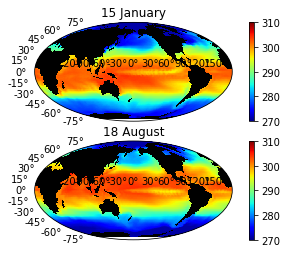

In [17]:
surface_temperatures["time"][4]

lon = np.subtract(surface_temperatures['lon'],180)
lat = surface_temperatures['lat']
sst = surface_temperatures['tos'][1,:,:]

fig, axs = plt.subplots(ncols=1, nrows=2, subplot_kw={'projection': "mollweide"})

pcm1 = axs[0].pcolormesh(np.radians(lon), np.radians(lat), sst, cmap=cmap, vmin=270, vmax=310)
axs[0].title.set_text('15 January')
fig.colorbar(pcm1, ax=axs[0])

lon = np.subtract(surface_temperatures['lon'],180)
lat = surface_temperatures['lat']
sst = surface_temperatures['tos'][20,:,:]

pcm2 = axs[1].pcolormesh(np.radians(lon), np.radians(lat), sst, cmap=cmap, vmin=270, vmax=310)
axs[1].title.set_text('18 August')
fig.colorbar(pcm2, ax=axs[1])

It's a little difficult to see anything here, let's try zooming in a little further.

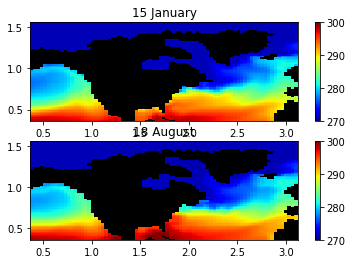

In [24]:
lon = surface_temperatures['lon'][100:]
lat = surface_temperatures['lat'][100:]

surface_temperatures["time"][4]

lon = np.subtract(surface_temperatures['lon'][100:],180)
lat = surface_temperatures['lat'][100:]
sst = surface_temperatures['tos'][1,100:,100:]

fig, axs = plt.subplots(ncols=1, nrows=2)

pcm1 = axs[0].pcolormesh(np.radians(lon), np.radians(lat), sst, cmap=cmap, vmin=270, vmax=300)
axs[0].title.set_text('15 January')
fig.colorbar(pcm1, ax=axs[0])

lon = np.subtract(surface_temperatures['lon'][100:],180)
lat = surface_temperatures['lat'][100:]
sst = surface_temperatures['tos'][4,100:,100:]

pcm2 = axs[1].pcolormesh(np.radians(lon), np.radians(lat), sst, cmap=cmap, vmin=270, vmax=300)
axs[1].title.set_text('18 August')
fig.colorbar(pcm2, ax=axs[1])

**Note that there are better ways to plot these data, such as `xarray`, but this works for an initial look**

We can start to see some differences in the surface temperatures, but overall this is still pretty obscure. Instead, let's go backwards and convert our data to 1-dimensional data. Then, we can calculate the
- mean temperature in each region, for each season
- repeat this process for some delimited regions across every time point in our dataset
- we can convert the numeric time to dates using some handy packages in `Python`

### Selecting and processing regions

We select the following regions of the ocean:
- **REGION 1** - 290-310 longitude, 30-50 latitude (U.S. East Coast)
- **REGION 2** - 230-250 longitude, 30-50 latitude (U.S. West Coast)
- **REGION 3** - 320-350 longitude, 60-70 latitude (Greenland Sea)

To take the average over the full area for each time point in the sampling period.

In [52]:
## REGION 1
long_indices = np.where((surface_temperatures['lon'][:] > 290) & (surface_temperatures['lon'][:] < 310))
lon = np.subtract(surface_temperatures['lon'][long_indices],180)
lat_indices = np.where((surface_temperatures['lat'][:] > 30) & (surface_temperatures['lat'][:] < 50))
lat = surface_temperatures['lat'][lat_indices]
sst = surface_temperatures['tos'][:,lat_indices[0],long_indices[0]]

# take mean over axis 1&2 (axis 0 is time)
mean_sst_region1 = np.mean(sst,(1, 2))

## REGION 2
long_indices = np.where((surface_temperatures['lon'][:] > 230) & (surface_temperatures['lon'][:] < 250))
lon = np.subtract(surface_temperatures['lon'][long_indices],180)
lat_indices = np.where((surface_temperatures['lat'][:] > 30) & (surface_temperatures['lat'][:] < 50))
lat = surface_temperatures['lat'][lat_indices]
sst = surface_temperatures['tos'][:,lat_indices[0],long_indices[0]]

# take mean over axis 1&2 (axis 0 is time)
mean_sst_region2 = np.mean(sst,(1, 2))

## REGION 3
long_indices = np.where((surface_temperatures['lon'][:] > 320) & (surface_temperatures['lon'][:] < 350))
lon = np.subtract(surface_temperatures['lon'][long_indices],180)
lat_indices = np.where((surface_temperatures['lat'][:] > 60) & (surface_temperatures['lat'][:] < 70))
lat = surface_temperatures['lat'][lat_indices]
sst = surface_temperatures['tos'][:,lat_indices[0],long_indices[0]]

# take mean over axis 1&2 (axis 0 is time)
mean_sst_region3 = np.mean(sst,(1, 2))

Now, we'll play with converting the time over, using the `datetime` package in Python.

In [62]:
times_all = surface_temperatures['time'][:].data # all of the times in days

In [65]:
date_start = datetime.datetime.strptime("1/1/2001", "%m/%d/%Y") # the start date in datetime format

timepoint_dates = [date_start + datetime.timedelta(days=curr) for curr in times_all]

Now, let's organize all of our data into a tidy `pandas` `DataFrame` to work with it more easily!

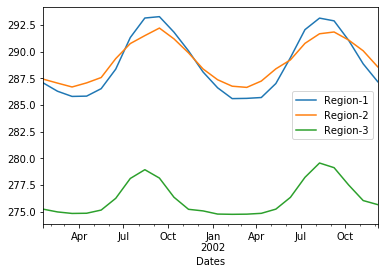

In [95]:
sst_summary = pd.DataFrame({"Dates": timepoint_dates,
              "Region-1": mean_sst_region1,
              "Region-2": mean_sst_region2,
              "Region-3": mean_sst_region3})
sst_summary

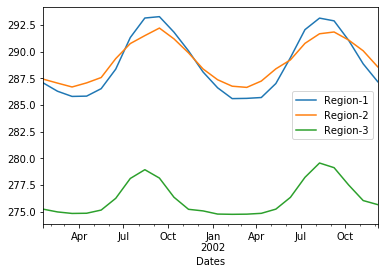

In [97]:
sst_summary.plot(x="Dates")

In [96]:
## We could also convert our data to a tidier format
pd.wide_to_long(sst_summary,stubnames="Region",i="Dates",j="Number",sep="-").reset_index()

,Dates,Number,Region
0,2001-01-16,1,287.076007
1,2001-02-15,1,286.282215
2,2001-03-17,1,285.796593
3,2001-04-16,1,285.823866
4,2001-05-16,1,286.523908
...,...,...,...
67,2002-08-09,3,279.558461
68,2002-09-08,3,279.122219
69,2002-10-08,3,277.501920
70,2002-11-07,3,276.040850


## Answering a research question with these data
Now that we've seen a few ways to manipulate and plot our data, perhaps we would like to give it a go to perform *statistical regression* on our data to establish some trend over space or time. 

In this case, we don't really have enough time points to establish any kind of time trend, using the dataset we picked. So instead, let's pick out a few different latitudes and see if we can establish a trend via _linear regression_. 

### Linear Regression

In linear regression, we have the goal of representing our data with a function in the format:

$$\begin{equation} y_{est} = \beta_0 + \beta_1 x + \epsilon \end{equation}$$

Where $y_{est}$ is some estimated response variable, $\beta_1$ and $\beta_2$ are *parameters* of the equation (you may have seen them expressed as $b$ and $m$, the y-intercept and slope, respectively), and $\epsilon$ is some error, because this regression procedure we're following is imperfect. In our case, because we're going to be modeling the changes in sea surface temperature (in Kelvin) along some latitude axis, we can name SST $s$ and latitude $a$ and have:

$$\begin{equation} \hat{s} = \beta_0 + \beta_1 a + \epsilon \end{equation}$$

#### Using linear algebra to estimate parameters

Where we use the notation $\hat{s}$ to denote that these are _estimated_ values for sea surface temperature. Because it wasn't covered in a previous math review, the way that we actually estimate these parameters $\beta_0$ and $\beta_1$, the unique values which describe our specific data, is using linear algebra. We can imagine our data in matrix-vector format, where $n$ is the total number of observations that we have:

$$\left[\begin{array}{c} s_0 \\ s_1 \\ \vdots \\ s_n \end{array}\right] = \left[ \begin{array}{cc} 1& a_0 \\ 1 & a_2 \\ \vdots & \vdots \\ 1 & a_n \end{array} \right] \left[ \begin{array}{c} \beta_0 \\ \beta_1 \end{array} \right]$$

Because $\beta_0$ is just multiplied by the identity to keep $\beta_0$ as the values, and $\beta_1$ has as its coefficient the latitude observations that we're using to generate a *straight-line model*.

We can say in general that this equation has the form $\mathbf{s} = \mathbf{E}\mathbf{b}$, where we use a capital letter to denote a matrix, in this case the matrix of the multipliers on our coefficients, and a lowercase letter to represent a vector (our SST predictions and the $\beta$ coefficients). We use **boldface** for both of these to indicate their multi-dimensionality.

So for every way that we define the parameters, we're going to have some error that we wish to minimize. Because the equation of the prediction is $\beta_0 + \beta_1 a$, this error can be represented as:

$$\textrm{error}(\beta_0, \beta_1) = \sum_{t=1}^n (s_t - (\beta_0 + \beta_1 a_t))^2 $$

So we solve the linear algebra-based matrix-form equation above to make the error expression we just wrote out *as small as possible*. This yields the following formula for the $\beta$ coefficients:

$$\mathbf{\beta}=(E^TE)^{-1}E^T s$$

Which has a derivation that we won't go through here, since we're talking through how to analyze data using available toolkits (but it's a cool process to know!). 

#### Estimating percentage of explained variance using $R^2$

A metric we often use to express the "percentage of variance explained", which is just a fancy way of how much of the trend we captured using the summary linear model, is called $R^2$, or the **coefficient of determination**. The formula for this value is:

$$R^2 = 1- \frac{\sum_{t=1}^n (s_t - (\beta_0 + \beta_1 a_t))^2 }{\sum_{t=1}^n (s_t - \bar{s})}$$

So in this case, we're calculating the error associated with our regression process ($\hat{s} = \beta_0 + \beta_1 a_t$) and dividing that by the difference of each one of our dependent variable values (SST measurements) from the *mean* of all of the SST measurements ($\bar{s}$). This gives us a ratio of how far off we are, relative to how different _all_ of the values we have are from the mean. We subtract this ratio from 1 to get how much of the variation _is_ explained, as opposed to expressing how far off we are.

## Extracting some values to regress on
This time, we'll write a *function* in `Python` in order to extract the mean SST at each latitude over the course of all time points.

In [101]:
# A function which takes as input a set of latitude and longitude bounds
# and then calculates & returns mean SST across time and longitude.
def extract_mean_sst_by_lat(min_lat, max_lat, min_lon, max_lon, sst_frame):
    long_indices = np.where((sst_frame['lon'][:] > min_lon) & \
                            (sst_frame['lon'][:] < max_lon))
    lat_indices = np.where((sst_frame['lat'][:] >= min_lat) & \
                           (sst_frame['lat'][:] <= max_lat)) # use >= so that we can use a single point
    
    lon = np.subtract(sst_frame['lon'][long_indices],180)
    lat = sst_frame['lat'][lat_indices]
    sst = surface_temperatures['tos'][:,lat_indices[0],long_indices[0]]
    
    mean_sst = np.mean(sst,(0,2))
    latitude_frame = pd.DataFrame({"Latitude": lat, "SST": mean_sst})
    
    return latitude_frame

We're just interested in _each_ available latitude across all times and longitudes, so we just give placeholder values for maximum.

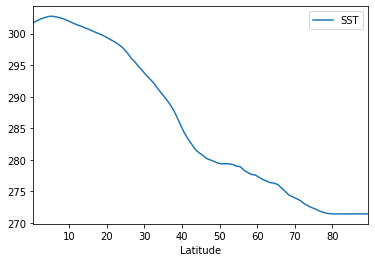

In [105]:
mean_by_lat = extract_mean_sst_by_lat(0, 500, 0, 500, surface_temperatures)
mean_by_lat.plot(x="Latitude",y="SST")

We will use `SciPy` to estimate a quick linear regression on these not-totally-linear data. 

In [110]:
scipy_linreg = scipy.stats.linregress(x = mean_by_lat.Latitude, y = mean_by_lat.SST)
scipy_linreg

LinregressResult(slope=-0.4352812287008252, intercept=305.1304619725177, rvalue=-0.9771853296131076, pvalue=5.3182628179698945e-61, stderr=0.010085152123907332)

Notice that `SciPy` is giving us $R$, which is correlation, and not $R^2$. We can see that the correlation between latitude and SST is negative (increasing latitude - closer to the poles - results in lower mean SST across longitudes). We can calculate $R^2$ to get percentage of variation explained:

In [118]:
scipy_linreg.rvalue**2

0.9548911684110777

So using this simple linear model, we can explain 95.4% of the variation in SST with latitude (*note*: correlation is not causation!).

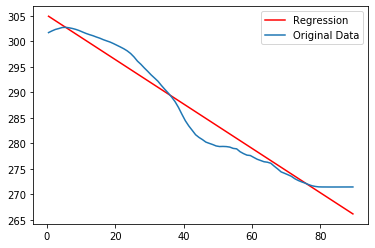

In [128]:
mean_by_lat["Regression"] = scipy_linreg.slope * mean_by_lat.Latitude + scipy_linreg.intercept

# Let's plot our data and regression using PyPlot
plt.plot(mean_by_lat.Latitude, mean_by_lat.Regression, color = "red", label = "Regression")
plt.plot(mean_by_lat.Latitude, mean_by_lat.SST, label = "Original Data")
plt.legend()

## Part 2: Biological Data and `FASTA` files via `SeqIO`!

We'll do a short example of parsing and investigating data from the mouse genome (*Mus musculus*). This is a sequence from chromosome 1 that I have subsetted (so it's a small fraction of the overall data just for the first chromosome) for the purposes of this exercise.

In [129]:
mouse_genome = list(SeqIO.parse("data/Mus_musculus_chr_1_subset.fa", "fasta"))

`SeqIO` allows us to treat every sequence in our FASTA file as an individual record and process it according to characteristics extracted from the `FASTA` format sequence file.

In [132]:
mouse_genome[0]

SeqRecord(seq=Seq('TCTTCCCTGATCGTCTGAGGGCTGAGGCTGTGGCACTGCCCGCAAAACTTCTAG...AAA', SingleLetterAlphabet()), id='samplefasta_header', name='samplefasta_header', description='samplefasta_header', dbxrefs=[])

The `SeqRecord` data type will always come with a field `seq` that is associated with every record inside of the `FASTA` file.

In [135]:
mouse_genome[0].seq

Seq('TCTTCCCTGATCGTCTGAGGGCTGAGGCTGTGGCACTGCCCGCAAAACTTCTAG...AAA', SingleLetterAlphabet())

We can perform typical array operations on these character array sequence entries.

In [140]:
len(mouse_genome[0].seq)

3030000